In [1]:
import warnings
import dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from paeio import io

import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
dotenv.load_dotenv()

True

In [2]:
df = io.read_parquet(
    'https://testmlopaes.dfs.core.windows.net/testing/raw/realtor-data.parquet',
    columns=['bed', 'bath', 'acre_lot', 'house_size', 'zip_code', 'state', 'price']
)

In [3]:
model_df = df.copy()
model_df = model_df[(model_df['bed'] > 0) & (model_df['bath'] > 0)]
#model_df['bed'] = model_df['bed'].fillna(0).astype(int)
#model_df['bath'] = model_df['bath'].fillna(0).astype(int)
model_df['1000sf'] = model_df['house_size']/1000
model_df['bed_per_1000sf'] = model_df['bed']/model_df['1000sf']
model_df['bath_per_1000sf'] = model_df['bath']/model_df['1000sf']
model_df['price_per_size'] = model_df['price']/model_df['house_size']
model_df['median_price_per_size'] = model_df.groupby(['zip_code'])['price_per_size'].transform('median')
model_df['median_local_price'] = model_df.groupby(['zip_code'])['price'].transform('median')
model_df['local_median_house_size'] = model_df.groupby(['zip_code'])['house_size'].transform('median')
model_df['house_size'] = model_df['house_size'].fillna(model_df['local_median_house_size'])
model_df['house_size_factor'] = model_df['house_size']/model_df['local_median_house_size']
model_df['check'] = model_df.groupby(['zip_code'])['acre_lot'].transform('median')
model_df['acre_lot_factor'] = (model_df['acre_lot']/model_df['check']).clip(upper=5).fillna(0)
model_df['acre_lot_factor'] = np.where(model_df['acre_lot_factor'] == np.inf, 1.2, model_df['acre_lot_factor'])
model_df = model_df[(model_df['price_per_size'] > model_df['median_price_per_size']*0.2) & (model_df['price_per_size'] < model_df['median_price_per_size']*5)]
tb_priced = model_df[model_df['price'].isnull()]
model_df = model_df[model_df['price'].notnull()]
model_df

,bed,bath,acre_lot,house_size,zip_code,state,price,1000sf,bed_per_1000sf,bath_per_1000sf,price_per_size,median_price_per_size,median_local_price,local_median_house_size,house_size_factor,check,acre_lot_factor
0,3.0,2.0,0.12,920.0,601.0,Puerto Rico,105000.0,0.920,3.260870,2.173913,114.130435,83.260371,92500.0,1223.5,0.751941,0.10,1.200000
1,4.0,2.0,0.08,1527.0,601.0,Puerto Rico,80000.0,1.527,2.619515,1.309758,52.390308,83.260371,92500.0,1223.5,1.248059,0.10,0.800000
2,2.0,1.0,0.15,748.0,795.0,Puerto Rico,67000.0,0.748,2.673797,1.336898,89.572193,104.112554,99500.0,1022.5,0.731540,0.09,1.666667
3,4.0,2.0,0.10,1800.0,731.0,Puerto Rico,145000.0,1.800,2.222222,1.111111,80.555556,80.555556,106000.0,1250.0,1.440000,0.24,0.416667
5,4.0,3.0,0.46,2520.0,612.0,Puerto Rico,179000.0,2.520,1.587302,1.190476,71.031746,90.000000,138000.0,1500.0,1.680000,0.21,2.190476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226377,4.0,2.0,0.33,3600.0,99354.0,Washington,359900.0,3.600,1.111111,0.555556,99.972222,211.356467,420000.0,2002.0,1.798202,0.20,1.650000
2226378,3.0,2.0,0.10,1616.0,99354.0,Washington,350000.0,1.616,1.856436,1.237624,216.584158,211.356467,420000.0,2002.0,0.807193,0.20,0.500000
2226379,6.0,3.0,0.50,3200.0,99354.0,Washington,440000.0,3.200,1.875000,0.937500,137.500000,211.356467,420000.0,2002.0,1.598402,0.20,2.500000
2226380,2.0,1.0,0.09,933.0,99354.0,Washington,179900.0,0.933,2.143623,1.071811,192.818864,211.356467,420000.0,2002.0,0.466034,0.20,0.450000


In [4]:
X = model_df[['median_local_price', 'house_size_factor', 'acre_lot_factor', 'bed_per_1000sf', 'bath_per_1000sf']]
y = model_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [5]:
model = XGBRegressor(n_estimators=10).fit(X_train, y_train)

xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'max_leaves': [4, 8],
    'learning_rate': [0.1, 0.3]
}
grid = GridSearchCV(model, xgb_param_grid, cv=6, n_jobs=-1).fit(X_train, y_train)
grid.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'max_leaves': 8, 'n_estimators': 100}

In [6]:
xgb_model = XGBRegressor(
    n_estimators=grid.best_params_['n_estimators'],
    max_depth=grid.best_params_['max_depth'],
    max_leaves=grid.best_params_['max_leaves'],
    learning_rate=grid.best_params_['learning_rate'],
    n_jobs=-1,
).fit(X_train, y_train)
pred = xgb_model.predict(X_test)

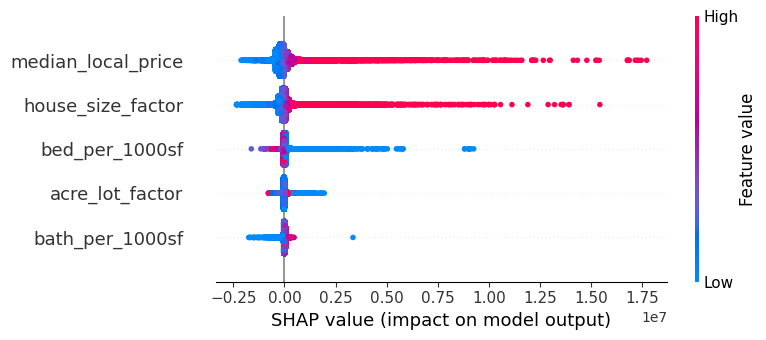

In [7]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [8]:
results = pd.DataFrame()
results['real'] = y_test
results['pred'] = pred.round()
results['error'] = (results['real'] - results['pred']).abs()
results['error_pct'] = ((results['pred']/results['real']) - 1).abs()
results

,real,pred,error,error_pct
2125352,3000000.0,1498550.0,1501450.0,0.500483
1555983,624900.0,796777.0,171877.0,0.275047
1182517,769990.0,700227.0,69763.0,0.090602
1350118,1195000.0,1572245.0,377245.0,0.315686
679628,68900.0,110653.0,41753.0,0.605994
...,...,...,...,...
770834,595000.0,513121.0,81879.0,0.137612
1512998,750000.0,982800.0,232800.0,0.310400
1549600,975000.0,926232.0,48768.0,0.050018
459409,625000.0,624202.0,798.0,0.001277


In [9]:
results.error.median()

61099.0

In [11]:
results.error_pct.median()

0.17293818181818177

In [12]:
X_test

,median_local_price,house_size_factor,acre_lot_factor,bed_per_1000sf,bath_per_1000sf
2125352,1499000.0,1.175847,0.933333,1.801802,1.201201
1555983,525000.0,1.504769,0.793103,1.014199,1.267748
1182517,750000.0,0.944735,0.565217,1.108955,0.831716
1350118,753658.0,1.849975,1.294118,1.095890,1.095890
679628,120000.0,0.874567,0.222222,2.967359,0.989120
...,...,...,...,...,...
770834,381000.0,1.252962,2.000000,2.364066,1.418440
1512998,627500.0,1.355358,2.946237,1.059771,0.847817
1549600,542000.0,2.002584,1.866667,1.612903,0.967742
459409,214900.0,2.270360,4.545455,1.176125,1.176125


In [13]:
import pickle

In [14]:
pickle.dump(xgb_model, open('house_model.pkl', "wb"))